<a href="https://colab.research.google.com/github/marinacer/IA048/blob/main/glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   aplicar scaling para todos exceto random forest 

2.   explicar o método minmaxscaler que é um scaler robusto a outliners
3.   algoritmos variados: svm é linear, knn não paramemtrico
random forest não linear, ensemble
4. oversampling para compensar o desbalanceamento das classes
5. matriz de confusão para os melhores hiperparamentos de cada método


In [2]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# open the csv file to dataframe
df = pd.read_csv('glass.csv')
df.head()

# divide o dataframe em treino e teste
dftrain, dftest = train_test_split(df, test_size = 0.30, stratify = df['Type'])

In [4]:
# aplica a técnica de oversampling para o df de treino
df3=dftrain[dftrain['Type']==3]
df3=pd.concat([df3]*4)

df5=dftrain[dftrain['Type']==5]
df5=pd.concat([df5]*5)

df6=dftrain[dftrain['Type']==6]
df6=pd.concat([df6]*7)

df7=dftrain[dftrain['Type']==7]
df7=pd.concat([df7]*2)

df1=dftrain[dftrain['Type']==1]
df2=dftrain[dftrain['Type']==2]

dftrain_over=pd.concat([df1,df2,df3,df5,df6,df7])



In [5]:
# divide o df em X e y já subdividos em treino e teste
Xtest = dftest.drop('Type',axis = 1)
ytest = dftest.Type

Xtrain = dftrain_over.drop('Type',axis = 1)
ytrain = dftrain_over.Type

In [6]:
# label encoding. necessário para corrigir um erro do dataset na nomenclatura das classes
label = preprocessing.LabelEncoder()
label.fit(ytrain)
ytrain = label.transform(ytrain)

label.fit(ytest)
ytest = label.transform(ytest)

In [7]:
# scaling com o fit no dado de treino já com oversampling e transform do dados de teste
from sklearn.preprocessing import RobustScaler,MinMaxScaler
scale = RobustScaler()

Xtrain_scaled = scale.fit_transform(Xtrain)
Xtest_scaled = scale.transform(Xtest)

In [8]:
# dataframe para np.array, necessário para realizar as operações de cross over
Xtrain = Xtrain.values
Xtest = Xtest.values

In [9]:
# cross validation, evaluation e desempenho do Random Forest
# por meio da variação de max_depth
def fit_random_forest(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)

  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      clf = RandomForestClassifier(max_depth = j+1, n_estimators = 500)
      clf.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = clf.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # execução Random Forest com o hiperparâmetro max_depth ideal
  clf = RandomForestClassifier(max_depth=best_var, n_estimators = 100)
  clf.fit(Xtrain_p, ytrain_p)
  y_predict = clf.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)
  return(best_var,f1_predict,acc_predict)

(12, 0.8408146591970121, 0.8461538461538461)

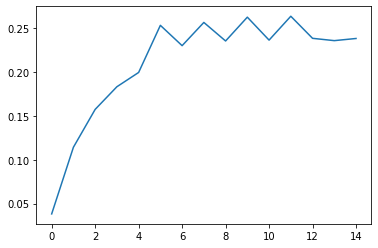

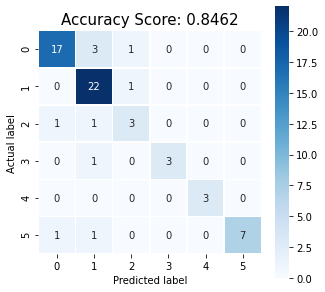

In [36]:
# oversampling
fit_random_forest(15,Xtrain,ytrain,Xtest,ytest)

(12, 0.7964661006521472, 0.8153846153846154)

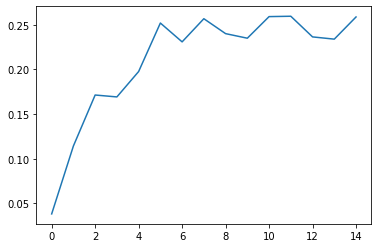

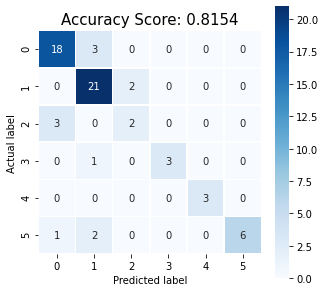

In [37]:
# scaling
fit_random_forest(15,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

In [9]:
# cross validation, evaluation e desempenho do KNN
# por meio da variação do nº de vizinhos
def fit_knn(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)
  
  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      neigh = KNeighborsClassifier(n_neighbors = j+1)
      neigh.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = neigh.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # execução KNN com o hiperparâmetro n_neighbors ideal
  neigh = KNeighborsClassifier(n_neighbors = best_var)
  neigh.fit(Xtrain_p, ytrain_p)
  y_predict = neigh.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

(1, 0.7063973063973065, 0.7076923076923077)

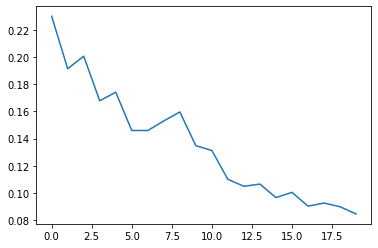

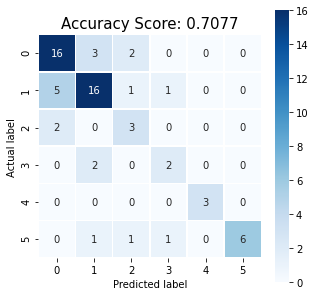

In [39]:
# oversampling
fit_knn(20,Xtrain,ytrain,Xtest,ytest)

(1, 0.7396469271469271, 0.7538461538461538)

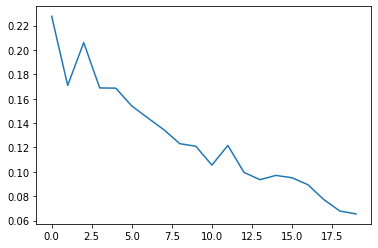

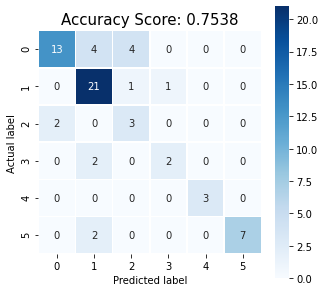

In [40]:
# oversampling + scaling
fit_knn(20,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

In [11]:
# cross validation, evaluation e desempenho do SVC
# por meio da variação do C
def fit_svc(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(len(var))
  
  for i,j in enumerate(var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):

      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      

      reg = SVC(gamma='auto',kernel='linear',C=j)
      reg.fit(Xtrain_kfold,ytrain_kfold)
      ypred_kfold = reg.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
      
    acc_vec[i] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = var[acc_vec.argmax()]

  # execução SVC com o hiperparâmetro C ideal
  reg = SVC(gamma='auto',kernel='linear',C=best_var)
  reg.fit(Xtrain_p,ytrain_p)
  y_predict = reg.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)
  
  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

In [15]:
vec_reg = [1e+2,1e+3,1e+4,1e+5]

(10000.0, 0.6208180708180707, 0.5846153846153846)

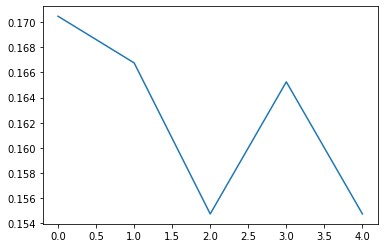

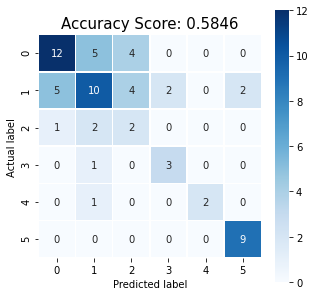

In [13]:
# oversampling
fit_svc(vec_reg,Xtrain,ytrain,Xtest,ytest)

(10000.0, 0.7065441381230855, 0.676923076923077)

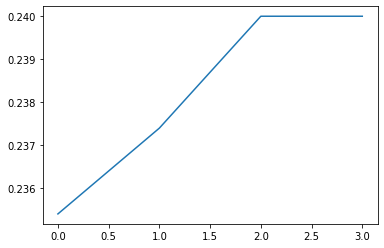

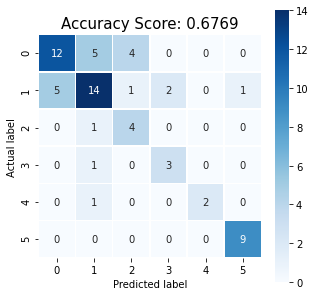

In [16]:
# oversampling + scaling
fit_svc(vec_reg,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

**Gráficos e Visualizações**

In [ ]:
# correlation matrix
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True, ax=ax,cmap="YlGnBu", center = 0)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


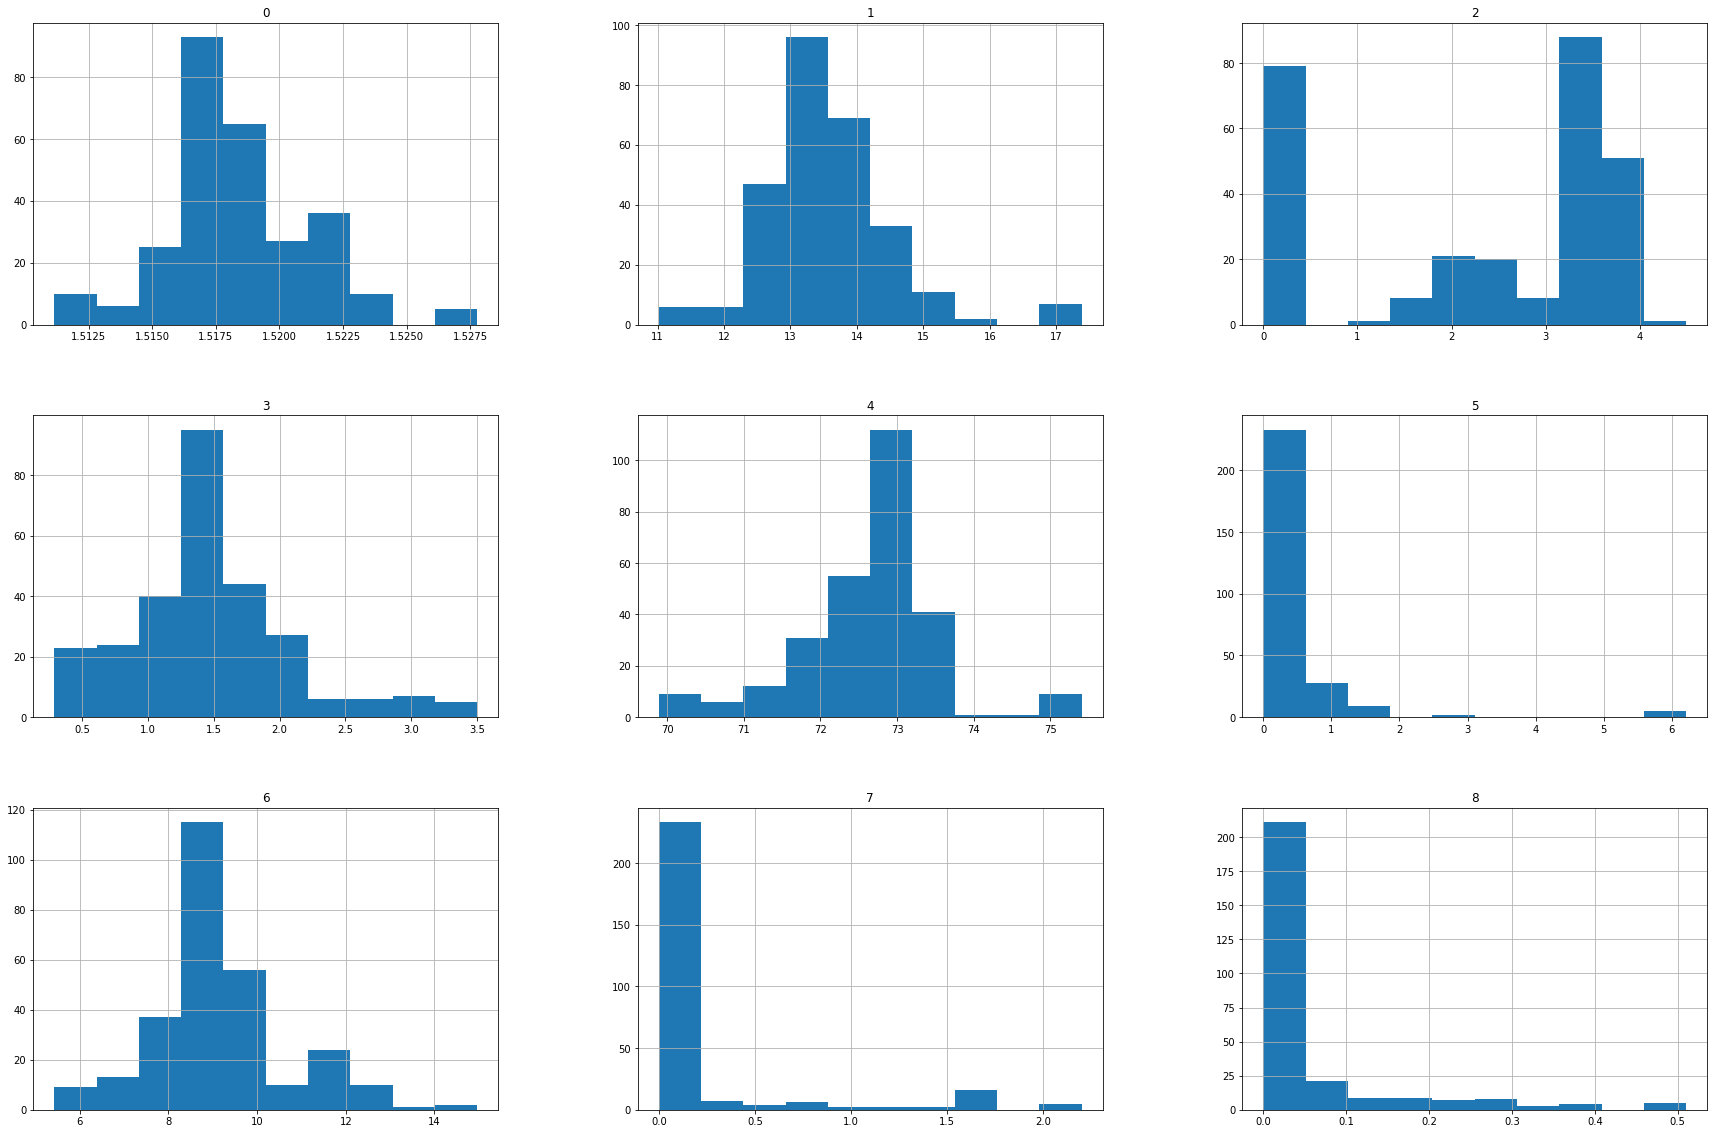

In [10]:
# histograma com scaling
Xtrainpd = pd.DataFrame(Xtrain)
fig, ax = plt.subplots(figsize=(30,20)) 
Xtrainpd.hist(ax = ax)
pass

In [ ]:
sns.FacetGrid(df,hue="Type",height=5).map(sns.distplot,"RI").add_legend();

No handles with labels found to put in legend.


[70 76 17 13  9 29]
[49 53 48 45 42 40]


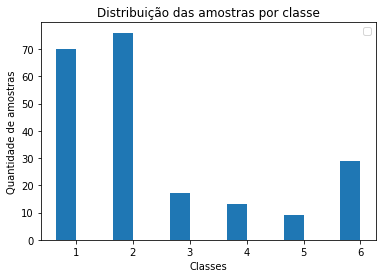

In [24]:
unique, counts = np.unique(df['Type'], return_counts=True)
unique, counts_over = np.unique(ytrain, return_counts=True)
print(counts)
print(counts_over)


labels = ['1', '2', '3', '4', '5', '6']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, counts, width)
#rects2 = ax.bar(x + width/2, counts_over, width, label='Oversampling')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantidade de amostras')
ax.set_xlabel('Classes')
ax.set_title('Distribuição das amostras por classe')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()